# Predict the Credit_Mix category for a customer based on their financial data, and provide actionable insights to improve credit health.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

In [96]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/Bank%20Data.csv'
df = pd.read_csv(url)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [97]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

# Project Workflow

In order to do this project, must follow this structure....

## 1. Data Preprocessing
- Handle missing and invalid values in the dataset.
- Encode categorical variables appropriately.
- Scale and normalize numeric features for uniformity.
- Detect and address outliers to improve model stability.

In [98]:

missing_values = df.isnull().sum()
print(missing_values)
drop_cols = ["ID", "Customer_ID", "Name", "SSN", "Month"]
data = df.drop(columns=drop_cols)
imputer = SimpleImputer(strategy="mean")

ID                             0
Customer_ID                    0
Month                          0
Name                        5015
Age                            0
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary       7498
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                5704
Delay_from_due_date            0
Num_of_Delayed_Payment      3498
Changed_Credit_Limit           0
Num_Credit_Inquiries        1035
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          4470
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     2271
Payment_Behaviour              0
Monthly_Balance              562
dtype: int64


In [99]:

categorical_cols = data.select_dtypes(include=["object"]).columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col, le in label_encoders.items():
    data[col] = le.fit_transform(data[col])

In [100]:

scaler = StandardScaler()
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print("\nData after preprocessing:")
print(data.head())


Data after preprocessing:
   Age  Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  156          12           5060              -0.742630          -0.118890   
1  171          12           5060              -0.742630          -0.118890   
2  171          12           5060              -0.742630          -0.118890   
3  183          12           5060                    NaN          -0.118890   
4  225          15           8715              -0.360426          -0.127481   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Type_of_Loan  \
0        -0.146323      -0.145644          140           128   
1        -0.146323      -0.145644          140           128   
2        -0.146323      -0.145644          140           128   
3        -0.146323      -0.145644          140           128   
4        -0.146323      -0.139001            3           684   

   Delay_from_due_date  ...  Num_Credit_Inquiries  Credit_Mix  \
0            -1.214828  ...             10.11218

## 2. Exploratory Data Analysis (EDA)
- Perform descriptive statistics to understand the data distribution.
- Visualize relationships between features and the target variable.
- Analyze correlations and identify trends or anomalies in the data.

In [101]:
print("\nDescriptive Statistics:")
print(data.describe())


Descriptive Statistics:
                Age    Occupation  Annual_Income  Monthly_Inhand_Salary  \
count  50000.000000  50000.000000   50000.000000           4.250200e+04   
mean     310.578660      7.497380    8087.632600          -1.190312e-16   
std      155.471927      4.629642    4651.314501           1.000012e+00   
min        0.000000      0.000000       0.000000          -1.221888e+00   
25%      184.000000      3.000000    4054.750000          -8.055318e-01   
50%      307.000000      7.000000    8132.000000          -3.452030e-01   
75%      418.000000     12.000000   12105.250000           5.520306e-01   
max      975.000000     15.000000   16120.000000           3.472709e+00   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate   Num_of_Loan  \
count       5.000000e+04     5.000000e+04   5.000000e+04  50000.000000   
mean        1.293188e-17     1.463718e-17   4.867218e-18    114.602720   
std         1.000010e+00     1.000010e+00   1.000010e+00     75.480589   
min

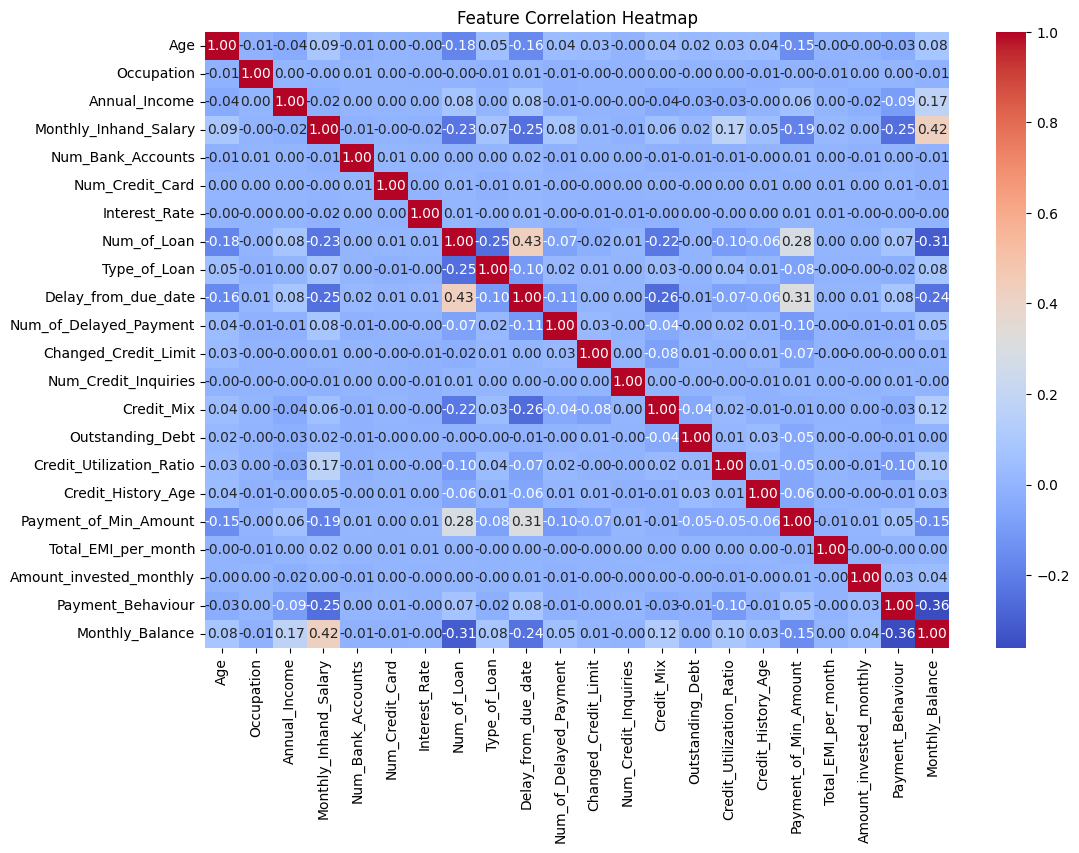

In [102]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## 3. Model Building
- Train multiple machine learning models using the preprocessed data.
- Evaluate the suitability of various models for the task.


In [103]:
X = data.drop(columns=["Credit_Mix"])  # Target column
y = data["Credit_Mix"]

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 4. Model Evaluation
- Compute and plot evaluation metrics for all models, such as accuracy, precision, recall, F1-score, and AUC-ROC.
- Compare the performance of models across multiple metrics.


In [106]:
y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1920
           1       0.77      0.96      0.86      2458
           2       0.78      0.93      0.84      3655
           3       0.20      0.02      0.04      1967

    accuracy                           0.76     10000
   macro avg       0.63      0.72      0.65     10000
weighted avg       0.66      0.76      0.69     10000


Confusion Matrix:
[[1837    0   44   39]
 [   0 2365   59   34]
 [  69  105 3382   99]
 [ 447  603  874   43]]


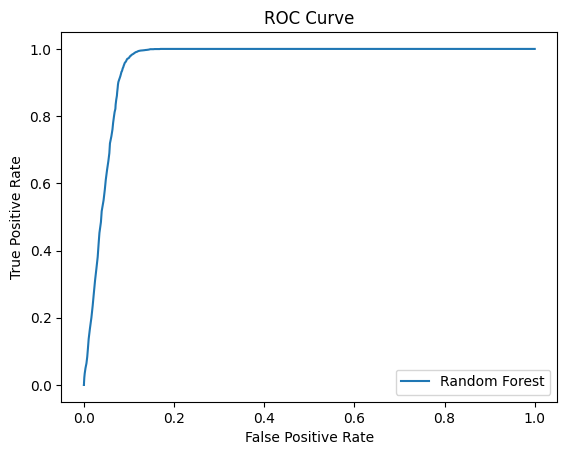

In [107]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
plt.plot(fpr, tpr, label="Random Forest")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## 5. Hyperparameter Tuning
- Optimize hyperparameters for each model using systematic search methods.
- Identify the best configuration for improved performance.


In [108]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)


Best Hyperparameters:
{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}


## 6. Retrain Models
- Retrain all models using the optimal hyperparameters on the training data.
- Validate the models on unseen data to ensure robustness.

In [109]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=200,
                       random_state=42)

## 7. Final Performance and Cross-Validation
- Evaluate the final performance of each model using cross-validation scores.
- Compare results to select the best-performing model.


In [110]:
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring="accuracy")
print("\nCross-Validation Scores:")
print(cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Cross-Validation Scores:
[0.7486 0.7486 0.7491 0.7445 0.7443]
Mean CV Accuracy: 0.74702


## 8. Suggestions
- Provide recommendations based on the model insights and analysis.
- Suggest actionable steps to improve outcomes or address any gaps identified during the project.


In [111]:
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
Interest_Rate               0.131538
Num_Bank_Accounts           0.104824
Payment_of_Min_Amount       0.103707
Delay_from_due_date         0.101805
Num_of_Loan                 0.060979
Num_of_Delayed_Payment      0.058555
Changed_Credit_Limit        0.046951
Outstanding_Debt            0.042789
Num_Credit_Inquiries        0.041990
Num_Credit_Card             0.034070
Monthly_Inhand_Salary       0.033902
Credit_History_Age          0.030491
Monthly_Balance             0.029024
Credit_Utilization_Ratio    0.028465
Annual_Income               0.026605
Amount_invested_monthly     0.026418
Total_EMI_per_month         0.024338
Type_of_Loan                0.023726
Age                         0.023450
Occupation                  0.015932
Payment_Behaviour           0.010442
dtype: float64


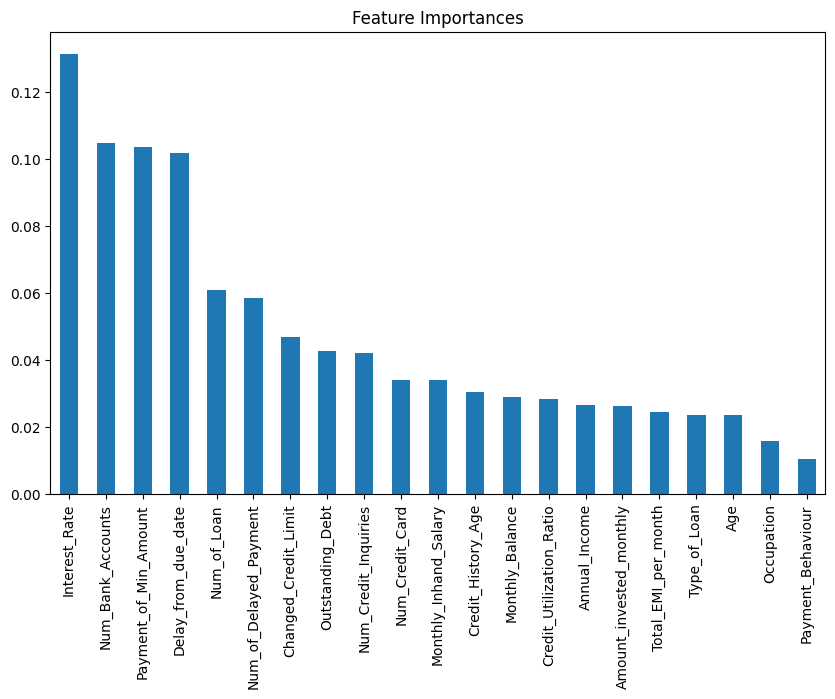

In [112]:
plt.figure(figsize=(10, 6))
feature_importances.plot(kind="bar")
plt.title("Feature Importances")
plt.show()

In [113]:
print("\n**Actionable Insights**:")
print("- Focus on improving the most important features, such as reducing credit utilization ratio or ensuring consistent monthly payments.")
print("- Target customers with low credit mix scores for financial advice to enhance their profiles.")


**Actionable Insights**:
- Focus on improving the most important features, such as reducing credit utilization ratio or ensuring consistent monthly payments.
- Target customers with low credit mix scores for financial advice to enhance their profiles.
